In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import tensorflow as tf
import glob

In [2]:
from collections import defaultdict

In [3]:
root_folder = './criteo_logs'

In [4]:
KL_folder = os.path.join(root_folder, 'KL')
##### fixed_scale is the setting where P is a constant function of the batch gradient properties.
##### no lower bound is concerned.
sumKL = {path[:len('KL_fixed_scale') + path[len('KL_fixed_scale'):].index('_')]: os.path.join(KL_folder, path) 
             for path in sorted(os.listdir(KL_folder))}
# for k, v in sumKL.items():
#     print(k, v)
#     print()
print(len(sumKL))

24


In [5]:
white_gaussian_folder = os.path.join(root_folder, 'white_gaussian')
white_gaussian = {
    path[:path.index('128')]: os.path.join(white_gaussian_folder, path)
        for path in sorted(os.listdir(white_gaussian_folder))
}

for k, v in white_gaussian.items():
    print(k, v)
    print()
print(len(white_gaussian))

white_gaussian_ratio0.25 ./criteo_logs/white_gaussian/white_gaussian_ratio0.25128128128noise_layer1281281281_batchsize1024_reg1_lr0.0001_datafrac0.9_20210522-14:16:35

white_gaussian_ratio0.5 ./criteo_logs/white_gaussian/white_gaussian_ratio0.5128128128noise_layer1281281281_batchsize1024_reg1_lr0.0001_datafrac0.9_20210520-01:56:48

white_gaussian_ratio0.75 ./criteo_logs/white_gaussian/white_gaussian_ratio0.75128128128noise_layer1281281281_batchsize1024_reg1_lr0.0001_datafrac0.9_20210522-14:16:34

white_gaussian_ratio1.0 ./criteo_logs/white_gaussian/white_gaussian_ratio1.0128128128noise_layer1281281281_batchsize1024_reg1_lr0.0001_datafrac0.9_20210520-01:56:48

white_gaussian_ratio1.25 ./criteo_logs/white_gaussian/white_gaussian_ratio1.25128128128noise_layer1281281281_batchsize1024_reg1_lr0.0001_datafrac0.9_20210520-01:56:48

white_gaussian_ratio1.5 ./criteo_logs/white_gaussian/white_gaussian_ratio1.5128128128noise_layer1281281281_batchsize1024_reg1_lr0.0001_datafrac0.9_20210520-01:56:48

In [6]:
no_noise_folder = os.path.join(root_folder, 'no_noise')
no_noise = {
    'no_noise': os.path.join(no_noise_folder, os.listdir(no_noise_folder)[0])
}
print(no_noise)

{'no_noise': './criteo_logs/no_noise/no_noise128128128noise_layer1281281281_batchsize1024_reg1_lr0.0001_datafrac0.9_20210520-01:56:48'}


In [7]:
expectation_align_folder = os.path.join(root_folder, 'expectation_align')
expectation_align = {'expectation_align': os.path.join(expectation_align_folder, os.listdir(expectation_align_folder)[0])}
print(expectation_align)

{'expectation_align': './criteo_logs/expectation_align/expectation_align128128128noise_layer1281281281_batchsize1024_reg1_lr0.0001_datafrac0.9_20210522-14:16:35'}


In [8]:
# perp_noise = {
#     'perpendicular_noise_lower1.0_upper5.0': 'run-perp_noise_perp_noise_lower1.0_upper5.0128128128128noise_layer1_batchsize65536_reg1_lr0.001^5000w0.0001^12000w2e-05_datafrac0.9_20201010-23_58_27',
#     'perpendicular_noise_lower1.0_upper10.0': 'run-perp_noise_perp_noise_lower1.0_upper10.0128128128128noise_layer1_batchsize65536_reg1_lr0.001^5000w0.0001^12000w2e-05_datafrac0.9_20201010-01_55_03',
#     'perpendicular_noise_lower1.0_upper15.0': 'run-perp_noise_perp_noise_lower1.0_upper15.0128128128128noise_layer1_batchsize65536_reg1_lr0.001^5000w0.0001^12000w2e-05_datafrac0.9_20201010-23_58_27',
# }

In [9]:
dictionary_of_dictionary = {'sumKL': sumKL,
                            'no_noise': no_noise,
                            'white_gaussian': white_gaussian,
                            'expectation_alignment': expectation_align,
#                             'perpendicular_noise': perp_noise,
                            }

In [10]:
def retrieve_all_tb_scalar_trajectories_from_single_path(folder_path):
    tb_event_file_path = glob.glob(pathname=os.path.join(folder_path, 'events*'))[0]
    result = defaultdict(list)
    for e in tf.compat.v1.train.summary_iterator(tb_event_file_path):
        for v in e.summary.value:
            value = tf.make_ndarray(v.tensor)
            if value.shape == ():
                result[v.tag].append((e.step,
                               value.item()))
            else:
                # any histogram information would be an actual tensor at any iteration e.step
                result[v.tag].append((e.step,
                               value))
    for tag_name in result:
        result[tag_name].sort(key=lambda x: x[0])
    return result

In [11]:
from tqdm import tqdm

In [12]:
from multiprocessing import Pool
def f(a):
    return a[0], retrieve_all_tb_scalar_trajectories_from_single_path(a[1])
def retrieve_all_tb_scalar_trajectories_from_many_methods(
        dictionary_of_dictionary):
    result = {}
    for category_name, category_dict in tqdm(dictionary_of_dictionary.items()):
        print(category_name)
        result[category_name] = {}
        with Pool(processes=20) as pool:
            for hyperparameter_instance, all_trajectories in pool.imap_unordered(f, category_dict.items()):
                result[category_name][hyperparameter_instance] = all_trajectories
#         for hyperparameter_instance, path in category_dict.items():
#             print(f'\t{hyperparameter_instance}')
#             result[category_name][hyperparameter_instance] = retrieve_all_tb_scalar_trajectories_from_single_path(path)
    return result

In [13]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [14]:
full_info_dict = retrieve_all_tb_scalar_trajectories_from_many_methods(dictionary_of_dictionary)

  0%|          | 0/4 [00:00<?, ?it/s]

sumKL


 25%|██▌       | 1/4 [02:59<08:57, 179.30s/it]

no_noise


 50%|█████     | 2/4 [04:08<04:52, 146.39s/it]

white_gaussian


 75%|███████▌  | 3/4 [06:50<02:30, 150.82s/it]

expectation_alignment


100%|██████████| 4/4 [07:59<00:00, 119.82s/it]


In [15]:
print(full_info_dict['sumKL'].keys())
print(full_info_dict["white_gaussian"].keys())
print(full_info_dict["expectation_alignment"].keys())
print(full_info_dict["no_noise"].keys())

dict_keys(['KL_fixed_scale5.0', 'KL_fixed_scale1.5', 'KL_fixed_scale4.0', 'KL_fixed_scale2.5', 'KL_fixed_scale0.4', 'KL_fixed_scale10.0', 'KL_fixed_scale25.0', 'KL_fixed_scale1.0', 'KL_fixed_scale0.3', 'KL_fixed_scale0.05', 'KL_fixed_scale0.01', 'KL_fixed_scale0.2', 'KL_fixed_scale2.0', 'KL_fixed_scale1.75', 'KL_fixed_scale0.25', 'KL_fixed_scale0.1', 'KL_fixed_scale20.0', 'KL_fixed_scale0.5', 'KL_fixed_scale3.0', 'KL_fixed_scale0.15', 'KL_fixed_scale6.0', 'KL_fixed_scale7.0', 'KL_fixed_scale8.0', 'KL_fixed_scale9.0'])
dict_keys(['white_gaussian_ratio3.5', 'white_gaussian_ratio6.0', 'white_gaussian_ratio3.0', 'white_gaussian_ratio25.0', 'white_gaussian_ratio1.5', 'white_gaussian_ratio1.25', 'white_gaussian_ratio0.25', 'white_gaussian_ratio4.0', 'white_gaussian_ratio4.5', 'white_gaussian_ratio2.75', 'white_gaussian_ratio2.0', 'white_gaussian_ratio1.75', 'white_gaussian_ratio15.0', 'white_gaussian_ratio2.25', 'white_gaussian_ratio0.5', 'white_gaussian_ratio1.0', 'white_gaussian_ratio0.75'

In [16]:
full_info_dict['sumKL']['KL_fixed_scale20.0']['deep_mask_layer_3_unit_128_norm_leak_batch']

[(1, 0.5172433853149414),
 (2, 0.4709489643573761),
 (3, 0.5253479480743408),
 (4, 0.5217033624649048),
 (5, 0.5047313570976257),
 (6, 0.49150732159614563),
 (7, 0.5067160725593567),
 (8, 0.5366925597190857),
 (9, 0.5040350556373596),
 (10, 0.4913851320743561),
 (11, 0.4800666570663452),
 (12, 0.496712327003479),
 (13, 0.47977784276008606),
 (14, 0.4923391342163086),
 (15, 0.4911649823188782),
 (16, 0.48111799359321594),
 (17, 0.4863739013671875),
 (18, 0.4977051317691803),
 (19, 0.5424702763557434),
 (20, 0.5388336181640625),
 (21, 0.49529197812080383),
 (22, 0.49238020181655884),
 (23, 0.5192780494689941),
 (24, 0.4956872761249542),
 (25, 0.5266263484954834),
 (26, 0.5237056612968445),
 (27, 0.5297549962997437),
 (28, 0.5173550844192505),
 (29, 0.490917831659317),
 (30, 0.4753206670284271),
 (31, 0.5057322382926941),
 (32, 0.5159083008766174),
 (33, 0.48330944776535034),
 (34, 0.5281899571418762),
 (35, 0.49601784348487854),
 (36, 0.5153212547302246),
 (37, 0.487221360206604),
 (38, 

In [17]:
def evaluate_single_run_tradeoff(
        run_name,
        all_trajectories,
        leak_tag_name, # determines which layer's leak AUC to evaluate
        leak_mean_or_max, # use average of |leakAUC - 0.5| over all batches or use max over all batches
        performance_tag_name, # the performance metric (could be 'train_loss', 'test_auc')
        leak_auc_baseline=0.0,# starting from 0.0 or 0.5
    ):
    leak_trajectory = all_trajectories[leak_tag_name]
    
#     print(run_name)
    if leak_mean_or_max == 'mean':
        leak = np.mean(np.absolute(np.array([a[1] for a in leak_trajectory]) - leak_auc_baseline))
    elif leak_mean_or_max == 'max':
#         leak = np.max(np.absolute(np.array([a[1] for a in leak_trajectory]) - 0.5))
#         print(f'max{np.max(np.absolute(np.array([a[1] for a in leak_trajectory]) - 0.5))}')
        leak = np.quantile(a=np.absolute(np.array([a[1] for a in leak_trajectory]) - leak_auc_baseline),
                           q=0.95,
                           interpolation='nearest')
#         print(f'95%{leak}')
#         print(f'5%{np.quantile(a=np.absolute(np.array([a[1] for a in leak_trajectory]) - 0.5),q=0.05,interpolation="nearest")}')
    else:
        assert False, 'unknown option'
    
    performance_trajectory = all_trajectories[performance_tag_name]
    if 'auc' in performance_tag_name or "accu" in performance_tag_name: # auc higher is better
#         performance = np.mean(sorted([a[1] for a in performance_trajectory])[-10:])
        performance = np.amax(np.array([a[1] for a in performance_trajectory]))
    elif 'loss' in performance_tag_name:
        performance = np.amin(np.array([a[1] for a in performance_trajectory]))
    else:
        assert False, 'unknown option'
    
    return (performance, leak, run_name)

In [18]:
def evaluate_one_method_complete_tradeoffs(hyperparameter_to_all_trajectories_dict,
                                           leak_tag_name,
                                           leak_mean_or_max, # use average of |leakAUC - 0.5| over all batches or use max over all batches
                                           performance_tag_name, # the performance metric (could be 'train_loss', 'test_auc')
                                           leak_auc_baseline,
                                          ):
    '''
    evaluate one method's (e.g. sumKL) performance privacy tradeoff at different hyperparameter choices
    return a tuple of two lists:
        privacy: a sorted list of the privacy metric at different hyperparameters
        performance: a matched list of the performance metric
    '''
    tradeoffs = []
    for hyperparameter, all_trajectories in hyperparameter_to_all_trajectories_dict.items():
        result = evaluate_single_run_tradeoff(
            run_name=hyperparameter,
            all_trajectories=all_trajectories,
            leak_tag_name=leak_tag_name,
            leak_mean_or_max=leak_mean_or_max,
            performance_tag_name=performance_tag_name,
            leak_auc_baseline=leak_auc_baseline)
        if result:
            tradeoffs.append(result)
    
    tradeoffs.sort(key=lambda a: a[0])
    performance, privacy, hyperparameter_names = map(list, zip(*tradeoffs))
    return performance, privacy, hyperparameter_names

In [19]:
# def plot_one_method_complete_tradeoffs(
#         hyperparameter_to_all_trajectories_dict,
#         leak_tag_name,
#         leak_mean_or_max, # use average of |leakAUC - 0.5| over all batches or use max over all batches
#         performance_tag_name, # the performance metric (could be 'train_loss', 'test_auc')
#         plot_title,
#         leak_auc_baseline=0.0,
#     ):
#     '''
#     evaluate one method's (e.g. sumKL) performance privacy tradeoff at different hyperparameter choices
#     return a tuple of two lists:
#         privacy: a sorted list of the privacy metric at different hyperparameters
#         performance: a matched list of the performance metric
#     '''
#     for hyperparameter, all_trajectories in hyperparameter_to_all_trajectories_dict.items():

#         tradeoff = evaluate_single_run_tradeoff(
#             run_name=hyperparameter,
#             all_trajectories=all_trajectories,
#             leak_tag_name=leak_tag_name,
#             leak_mean_or_max=leak_mean_or_max,
#             performance_tag_name=performance_tag_name,
#             leak_auc_baseline=leak_auc_baseline)
#         if tradeoff:
#             plt.plot([tradeoff[0]], [tradeoff[1]], 'o', label=hyperparameter)

#     if leak_auc_start <= 0.01:
#         plt.ylabel(r'{} leak_auc'.format(leak_mean_or_max))
#     else:
#         plt.ylabel(r'{} |leak_auc - 0.5|'.format(leak_mean_or_max))
#     plt.xlabel(r'{}'.format(performance_tag_name))
#     plt.title(plot_title)

In [20]:
def plot_different_methods_tradeoff_curves(
        multiple_methods_info_dict,
        leak_tag_name,
        leak_mean_or_max,
        performance_tag_name,
        plot_title,
        y_label,
        leak_auc_baseline=0.0,
        ):

    for method_name in multiple_methods_info_dict:

        performance_list, privacy_list, hyperparameter_list = \
            evaluate_one_method_complete_tradeoffs(
                hyperparameter_to_all_trajectories_dict=multiple_methods_info_dict[method_name],
                leak_tag_name=leak_tag_name,
                leak_mean_or_max=leak_mean_or_max,
                performance_tag_name=performance_tag_name,
                leak_auc_baseline=leak_auc_baseline)

        plt.plot(performance_list, privacy_list, 'o', label=method_name)
    plt.legend()
    if leak_auc_baseline == 0.0:
        plt.ylabel(f'{y_label}')
    else:
        plt.ylabel(f'|{y_label} - {leak_auc_baseline}|')
    plt.xlabel(f'{performance_tag_name}')
    plt.title(plot_title)

In [21]:
evaluate_single_run_tradeoff(
        run_name='no_noise',
        all_trajectories=full_info_dict['no_noise']['no_noise'],
        leak_tag_name='deep_mask_layer_3_unit_128_norm_leak_batch', # determines which layer's leak AUC to evaluate
        leak_mean_or_max='max', # use average of |leakAUC - 0.5| over all batches or use max over all batches
        performance_tag_name='test_auc', # the performance metric (could be 'train_loss', 'test_auc',
        leak_auc_baseline=0.5,
    )

(0.780952513217926, 0.4510853886604309, 'no_noise')

In [22]:
perf, priv, name = evaluate_one_method_complete_tradeoffs(
    hyperparameter_to_all_trajectories_dict=full_info_dict['sumKL'],
    leak_tag_name='deep_mask_layer_3_unit_128_norm_leak_batch', # determines which layer's leak AUC to evaluate
    leak_mean_or_max='max', # use average of |leakAUC - 0.5| over all batches or use max over all batches
    performance_tag_name='test_auc', # the performance metric (could be 'train_loss', 'test_auc')
    leak_auc_baseline=0.5,
)
for a,b,c in zip(perf, priv, name):
    print(a,b,c)

0.7417713403701782 0.041537702083587646 KL_fixed_scale25.0
0.7446631193161011 0.0417790412902832 KL_fixed_scale20.0
0.7515156269073486 0.043893277645111084 KL_fixed_scale10.0
0.7528210878372192 0.04454243183135986 KL_fixed_scale9.0
0.7536996006965637 0.04599475860595703 KL_fixed_scale8.0
0.7548302412033081 0.04733031988143921 KL_fixed_scale7.0
0.7556516528129578 0.049365997314453125 KL_fixed_scale6.0
0.7573311924934387 0.05257987976074219 KL_fixed_scale5.0
0.759270191192627 0.05805164575576782 KL_fixed_scale4.0
0.7615911364555359 0.06767106056213379 KL_fixed_scale3.0
0.7628803849220276 0.07236158847808838 KL_fixed_scale2.5
0.764148473739624 0.08242368698120117 KL_fixed_scale2.0
0.7648974657058716 0.09299719333648682 KL_fixed_scale1.75
0.7666926980018616 0.10100555419921875 KL_fixed_scale1.5
0.7687027454376221 0.1172412633895874 KL_fixed_scale1.0
0.7725797295570374 0.17284566164016724 KL_fixed_scale0.5
0.7739737033843994 0.19034922122955322 KL_fixed_scale0.4
0.7750980854034424 0.2301670

In [23]:
perf, priv, name = evaluate_one_method_complete_tradeoffs(
    hyperparameter_to_all_trajectories_dict=full_info_dict['white_gaussian'],
    leak_tag_name='deep_mask_layer_3_unit_128_norm_leak_batch', # determines which layer's leak AUC to evaluate
    leak_mean_or_max='max', # use average of |leakAUC - 0.5| over all batches or use max over all batches
    performance_tag_name='test_auc', # the performance metric (could be 'train_loss', 'test_auc')
    leak_auc_baseline=0.5,
)
for a,b,c in zip(perf, priv, name):
    print(a,b,c)

0.7276555299758911 0.04054689407348633 white_gaussian_ratio25.0
0.744361162185669 0.04146987199783325 white_gaussian_ratio15.0
0.7490434050559998 0.04367932677268982 white_gaussian_ratio11.0
0.7518414258956909 0.046539306640625 white_gaussian_ratio9.0
0.756488025188446 0.05314457416534424 white_gaussian_ratio7.0
0.7571825385093689 0.05932861566543579 white_gaussian_ratio6.0
0.7614918947219849 0.07878059148788452 white_gaussian_ratio4.5
0.7617177367210388 0.06999266147613525 white_gaussian_ratio5.0
0.7636376619338989 0.08920258283615112 white_gaussian_ratio4.0
0.7656700611114502 0.10628074407577515 white_gaussian_ratio3.5
0.7682130336761475 0.13099521398544312 white_gaussian_ratio3.0
0.7687005996704102 0.14823883771896362 white_gaussian_ratio2.75
0.7706761360168457 0.17100179195404053 white_gaussian_ratio2.5
0.7713000178337097 0.1982729434967041 white_gaussian_ratio2.25
0.7723722457885742 0.23063331842422485 white_gaussian_ratio2.0
0.7738391160964966 0.2730296850204468 white_gaussian_ra

In [24]:
evaluate_single_run_tradeoff(
        run_name='no_noise',
        all_trajectories=full_info_dict['no_noise']['no_noise'],
        leak_tag_name='deep_mask_layer_3_unit_128_norm_leak_batch', # determines which layer's leak AUC to evaluate
        leak_mean_or_max='max', # use average of |leakAUC - 0.5| over all batches or use max over all batches
        performance_tag_name='test_auc', # the performance metric (could be 'train_loss', 'test_auc')
        leak_auc_baseline=0.5,
    )

(0.780952513217926, 0.4510853886604309, 'no_noise')

In [25]:
# plot_one_method_complete_tradeoffs(
#         hyperparameter_to_all_trajectories_dict=full_info_dict['sumKL'],
#         leak_tag_name='mask_layer_4_conv64_cosine_leak_batch', # determines which layer's leak AUC to evaluate
#         leak_mean_or_max='max', # use average of |leakAUC - 0.5| over all batches or use max over all batches
#         performance_tag_name='test_auc', # the performance metric (could be 'train_loss', 'test_auc')
#         plot_title='sumKL'
#     )

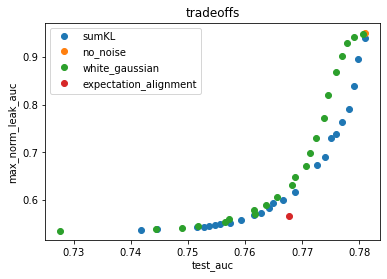

In [26]:
plot_different_methods_tradeoff_curves(
    multiple_methods_info_dict=full_info_dict,
        leak_tag_name='deep_mask_layer_3_unit_128_norm_leak_batch', # determines which layer's leak AUC to evaluate
        leak_mean_or_max='max', # use average of |leakAUC - 0.5| over all batches or use max over all batches
        performance_tag_name='test_auc', # the performance metric (could be 'train_loss', 'test_auc'),
        plot_title='tradeoffs',
        y_label='max_norm_leak_auc',
        leak_auc_baseline=0.0,
    )
# 'deep_mask_layer_3_unit_128_norm_leak_batch'

Generate the leak AUC progression statistics

In [27]:
def plot(info, label):
    l, = plt.plot([x[0] for x in info], [x[1] for x in info], label=label)
    return l

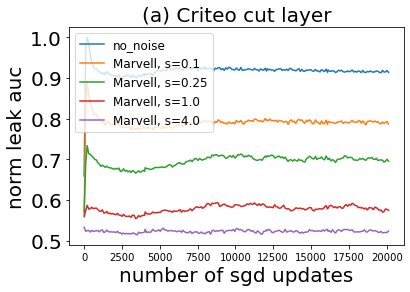

In [28]:
legend_handles = []
import matplotlib
matplotlib.rcParams["legend.framealpha"] = 0.8

leak_name = 'deep_mask_layer_3_unit_128_norm_leak'
legend_handles.append(plot(full_info_dict['no_noise']['no_noise'][leak_name],
                           label='no_noise'))
legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale0.1'][leak_name],
                           label='Marvell, s=0.1'))
legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale0.25'][leak_name],
                           label='Marvell, s=0.25'))
# legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale0.5']['mask_layer_4_conv64_norm_leak'],
#                            label='Marvell, s=0.5'))
legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale1.0'][leak_name],
                           label='Marvell, s=1.0'))
# legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale2.0']['mask_layer_4_conv64_norm_leak'],
#                            label='Marvell, s=2.0'))
legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale4.0'][leak_name],
                           label='Marvell, s=4.0'))


plt.legend(handles=legend_handles, fontsize=12)
plt.title('(a) Criteo cut layer', fontsize=20)
plt.xlabel('number of sgd updates', fontsize=20)
plt.ylabel('norm leak auc', fontsize=20)
plt.yticks(fontsize=20)
# plt.subplots_adjust(left=0.12, 
#             bottom=0.13,
#             top=0.92,
#             right=0.99)
plt.savefig('a_criteo_norm_leak_auc_cut_layer.pdf', bbox_inches='tight', pad_inches=0.0)

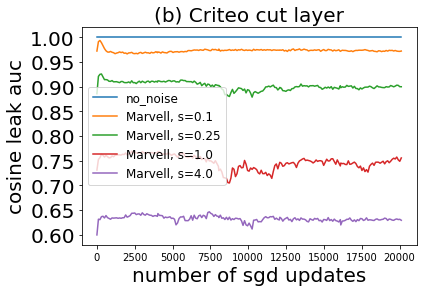

In [29]:
legend_handles = []
# import matplotlib
matplotlib.rcParams["legend.framealpha"] = 0.8

leak_name = 'deep_mask_layer_3_unit_128_cosine_leak'
legend_handles.append(plot(full_info_dict['no_noise']['no_noise'][leak_name],
                           label='no_noise'))
legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale0.1'][leak_name],
                           label='Marvell, s=0.1'))
legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale0.25'][leak_name],
                           label='Marvell, s=0.25'))
# legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale0.5']['mask_layer_4_conv64_norm_leak'],
#                            label='Marvell, s=0.5'))
legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale1.0'][leak_name],
                           label='Marvell, s=1.0'))
# legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale2.0']['mask_layer_4_conv64_norm_leak'],
#                            label='Marvell, s=2.0'))
legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale4.0'][leak_name],
                           label='Marvell, s=4.0'))


plt.legend(handles=legend_handles, fontsize=12)
plt.title('(b) Criteo cut layer', fontsize=20)
plt.xlabel('number of sgd updates', fontsize=20)
plt.ylabel('cosine leak auc', fontsize=20)
plt.yticks(fontsize=20)
# plt.subplots_adjust(left=0.12, 
#             bottom=0.13,
#             top=0.92,
#             right=0.99)
plt.savefig('b_criteo_cosine_leak_auc_cut_layer.pdf', bbox_inches='tight', pad_inches=0.0)

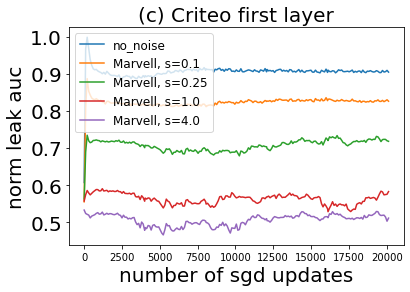

In [30]:
legend_handles = []
# import matplotlib
matplotlib.rcParams["legend.framealpha"] = 0.8

leak_name = 'deep_mask_layer_1_unit_128_norm_leak'
legend_handles.append(plot(full_info_dict['no_noise']['no_noise'][leak_name],
                           label='no_noise'))
legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale0.1'][leak_name],
                           label='Marvell, s=0.1'))
legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale0.25'][leak_name],
                           label='Marvell, s=0.25'))
# legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale0.5']['mask_layer_4_conv64_norm_leak'],
#                            label='Marvell, s=0.5'))
legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale1.0'][leak_name],
                           label='Marvell, s=1.0'))
# legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale2.0']['mask_layer_4_conv64_norm_leak'],
#                            label='Marvell, s=2.0'))
legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale4.0'][leak_name],
                           label='Marvell, s=4.0'))


plt.legend(handles=legend_handles, fontsize=12)
plt.title('(c) Criteo first layer', fontsize=20)
plt.xlabel('number of sgd updates', fontsize=20)
plt.ylabel('norm leak auc', fontsize=20)
plt.yticks(fontsize=20)
# plt.subplots_adjust(left=0.12, 
#             bottom=0.13,
#             top=0.92,
#             right=0.99)
plt.savefig('c_criteo_norm_leak_auc_first_layer.pdf', bbox_inches='tight', pad_inches=0.0)

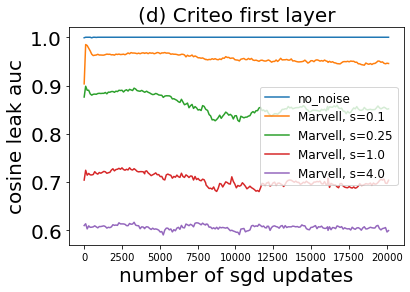

In [31]:
legend_handles = []
# import matplotlib
matplotlib.rcParams["legend.framealpha"] = 0.8

leak_name = 'deep_mask_layer_1_unit_128_cosine_leak'
legend_handles.append(plot(full_info_dict['no_noise']['no_noise'][leak_name],
                           label='no_noise'))
legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale0.1'][leak_name],
                           label='Marvell, s=0.1'))
legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale0.25'][leak_name],
                           label='Marvell, s=0.25'))
# legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale0.5']['mask_layer_4_conv64_norm_leak'],
#                            label='Marvell, s=0.5'))
legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale1.0'][leak_name],
                           label='Marvell, s=1.0'))
# legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale2.0']['mask_layer_4_conv64_norm_leak'],
#                            label='Marvell, s=2.0'))
legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale4.0'][leak_name],
                           label='Marvell, s=4.0'))


plt.legend(handles=legend_handles, fontsize=12)
plt.title('(d) Criteo first layer', fontsize=20)
plt.xlabel('number of sgd updates', fontsize=20)
plt.ylabel('cosine leak auc', fontsize=20)
plt.yticks(fontsize=20)
# plt.subplots_adjust(left=0.12, 
#             bottom=0.13,
#             top=0.92,
#             right=0.99)
plt.savefig('d_criteo_cosine_leak_auc_first_layer.pdf', bbox_inches='tight', pad_inches=0.0)

In [43]:
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42
# matplotlib.rcParams.update({'font.size': 22}) # change fonts size when text is too small to read
from matplotlib.ticker import FormatStrFormatter

def scatter_plot_different_methods_tradeoff_curves(
        multiple_methods_info_dict,
        leak_tag_name,
        leak_mean_or_max,
        performance_tag_name,
        plot_title,
        xlabel,
        ylabel,
        save_file_name,
        leak_auc_baseline=0.0,):
    
    fig, axes = plt.subplots(1, 1, figsize=(12, 10))
    
    for method_name in ['white_gaussian', 'sumKL', 'expectation_alignment', 'no_noise']:#multiple_methods_info_dict:
        performance, privacy, hyper_names = evaluate_one_method_complete_tradeoffs(
            hyperparameter_to_all_trajectories_dict=multiple_methods_info_dict[method_name],
            leak_tag_name=leak_tag_name,
            leak_mean_or_max=leak_mean_or_max,
            leak_auc_baseline=leak_auc_baseline,
            performance_tag_name=performance_tag_name)

        if method_name == 'white_gaussian':
            axes.scatter(performance, privacy, c="#cc8374", label="iso", marker = "^", s = 400.0)
        elif method_name == 'no_noise':
            axes.scatter(performance, privacy, c="#FFC222", label="no_noise", marker = "s", s = 400.0)
        elif method_name == 'sumKL':
            axes.scatter(performance, privacy, c="#33FF82", label="Marvell", marker = "o", s = 400.0)
        elif method_name == 'expectation_alignment':
            axes.scatter(performance, privacy, c="#33A8FF", label="max_norm", marker = "*", s = 400.0)
       
#     axes.legend(loc="lower right")
    axes.legend(fontsize=36)
    font_size = 42
    axes.grid(b = True, linestyle="dashed")
    axes.set_xlabel(xlabel, fontsize=font_size)
    axes.set_ylabel(ylabel, fontsize=font_size)
    axes.tick_params(axis="x", labelsize=font_size - 12)
    axes.tick_params(axis="y", labelsize=font_size)
    axes.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

#     if leak_auc_start <= 0.01:
#         plt.xlabel(r'{} leak_auc'.format(leak_mean_or_max))
#     else:
#         plt.xlabel(r'{} |leak_auc - 0.5|'.format(leak_mean_or_max))
    plt.title(plot_title, fontsize=42)
    fig.savefig(save_file_name, bbox_inches='tight', pad_inches=0.0)

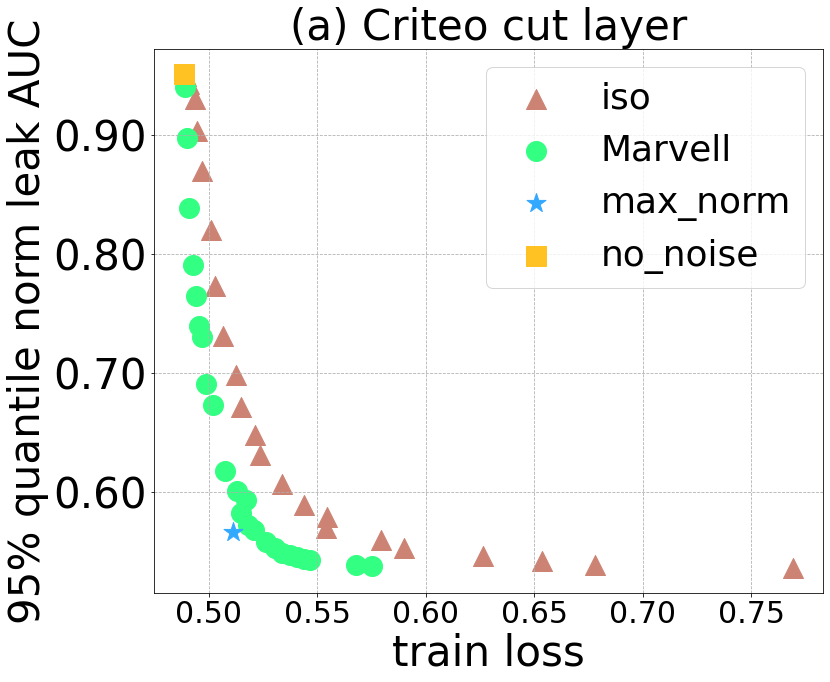

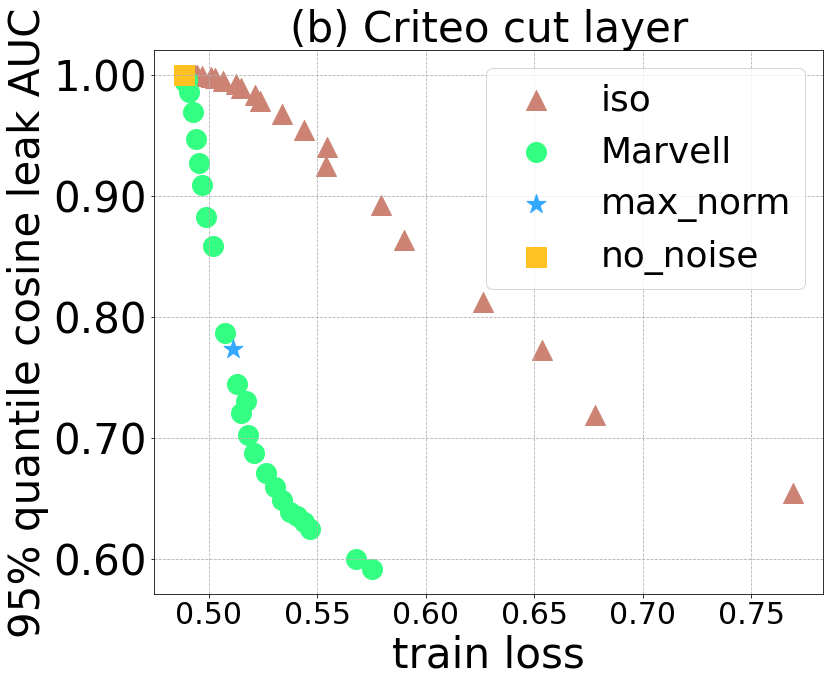

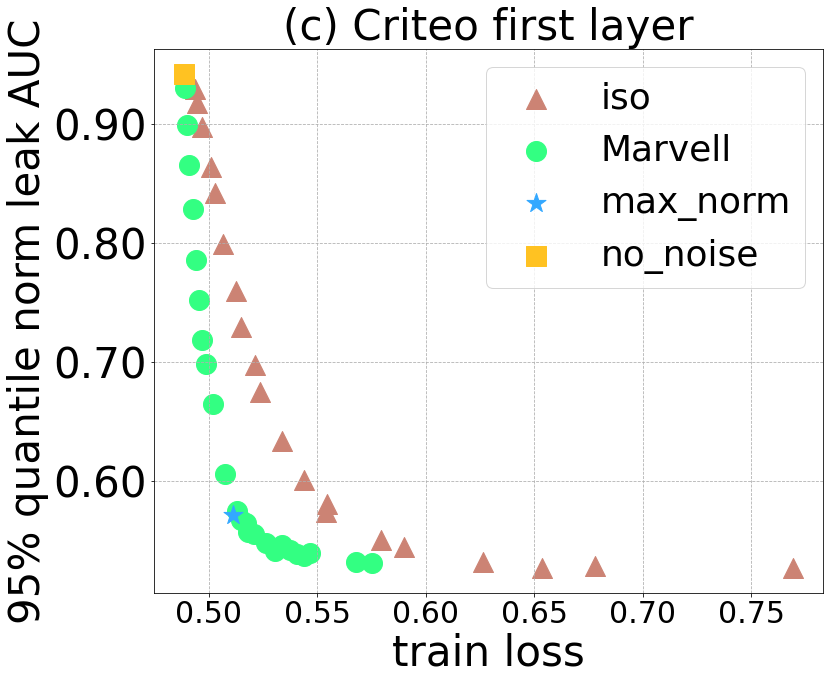

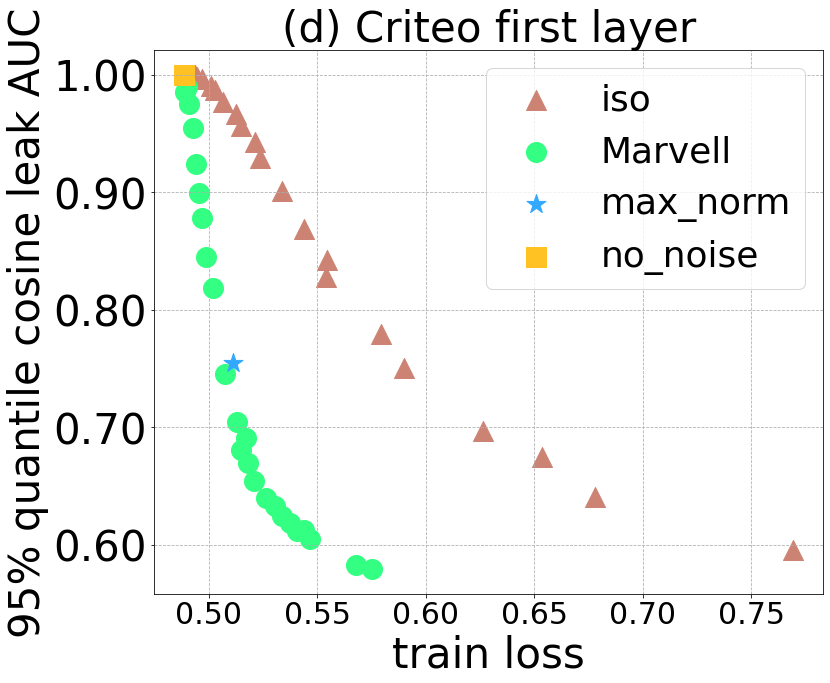

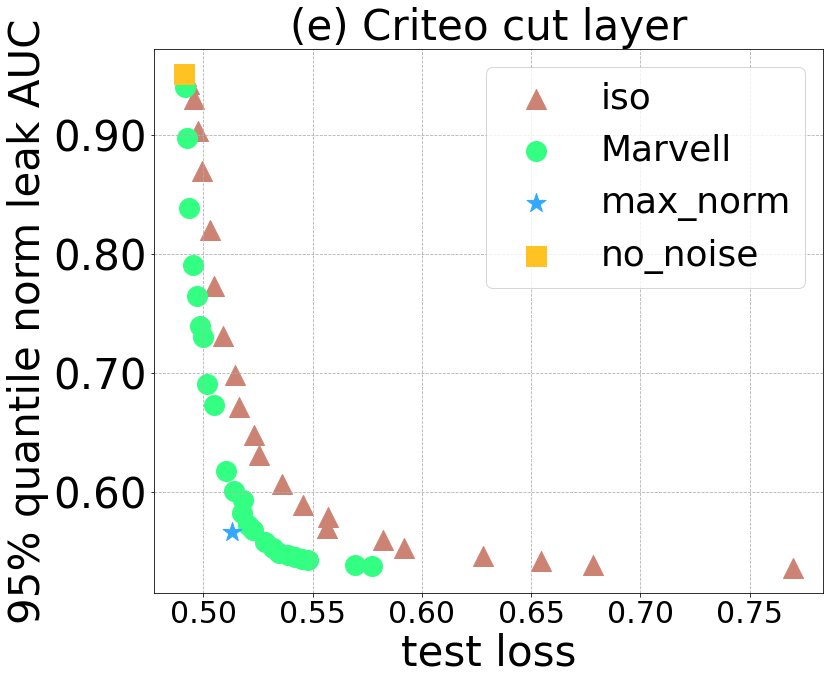

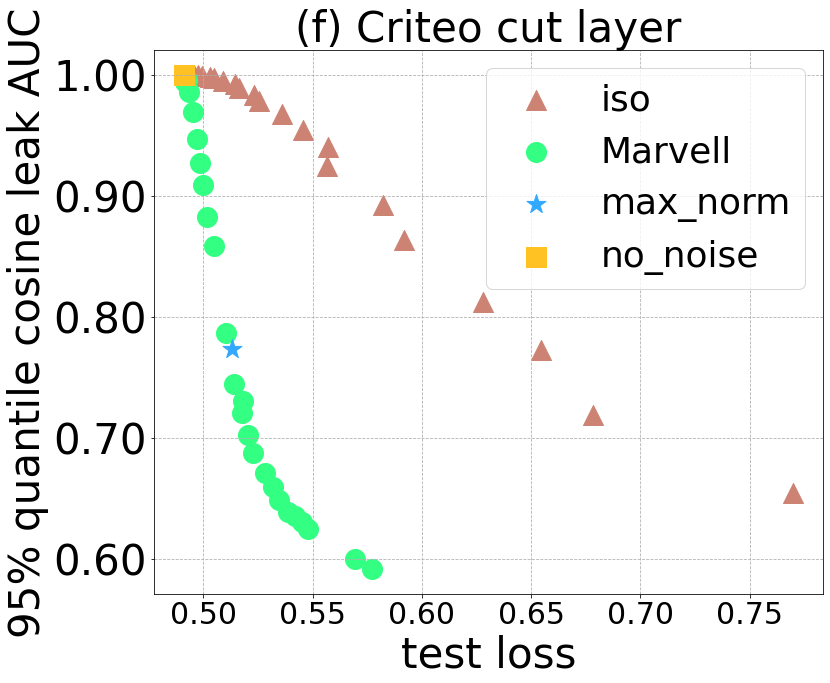

In [ ]:
leak_tag_dict = {
    'norm_cut': 'deep_mask_layer_3_unit_128_norm_leak_batch',
    'norm_first': 'deep_mask_layer_1_unit_128_norm_leak_batch',
    'cosine_cut': 'deep_mask_layer_3_unit_128_cosine_leak_batch',
    'cosine_first': 'deep_mask_layer_1_unit_128_cosine_leak_batch'
}
perf_tag_list = ['train_loss', 'test_loss', 'test_auc']

pair_list = [
    ('train_loss', leak_tag_dict['norm_cut'], 'a'),
    ('train_loss', leak_tag_dict['cosine_cut'], 'b'),
    ('train_loss', leak_tag_dict['norm_first'], 'c'),
    ('train_loss', leak_tag_dict['cosine_first'], 'd'),
    ('test_loss', leak_tag_dict['norm_cut'], 'e'),
    ('test_loss', leak_tag_dict['cosine_cut'], 'f'),
    ('test_loss', leak_tag_dict['norm_first'], 'g'),
    ('test_loss', leak_tag_dict['cosine_first'], 'h'),
    ('test_auc', leak_tag_dict['norm_cut'], 'i'),
    ('test_auc', leak_tag_dict['cosine_cut'], 'j'),
    ('test_auc', leak_tag_dict['norm_first'], 'k'),
    ('test_auc', leak_tag_dict['cosine_first'], 'l'),
]

for perf_tag, leak_tag, label in pair_list:
        if 'cosine' in leak_tag:
            ylabel = '95% quantile cosine leak AUC'
        else:
            ylabel = '95% quantile norm leak AUC'
        if perf_tag == 'test_auc':
            xlabel = 'test auc'
        elif perf_tag == 'test_loss':
            xlabel = 'test loss'
        elif perf_tag == 'train_loss':
            xlabel = 'train loss'
        else:
            assert False
        
        if 'mask_layer_3' in leak_tag:
            plot_title = 'Criteo cut layer'
        else:
            plot_title = 'Criteo first layer'
        
        scatter_plot_different_methods_tradeoff_curves(
                multiple_methods_info_dict=full_info_dict,
                leak_tag_name=leak_tag, # determines which layer's leak AUC to evaluate
                leak_mean_or_max='max', # use average of |leakAUC - 0.5| over all batches or use max over all batches
                performance_tag_name=perf_tag, # the performance metric (could be 'train_loss', 'test_auc')
                xlabel=xlabel,
                ylabel=ylabel,
                plot_title=f'({label}) ' + plot_title,
                save_file_name=f"{label}_Criteo_{perf_tag}_{leak_tag}.pdf"
            )